

# Практическая работа №2 "Анализ логов"

Выполнил студент группы ББМО-01-23 Стрыбак В.В.

Вариант №10: 25 mod 16 + 1 = 10 (OpenSSH)


Клонирование репозитория с логами для их анализа


In [2]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 575 (delta 145), reused 135 (delta 132), pack-reused 404 (from 1)
Receiving objects: 100% (575/575), 7.27 MiB | 7.97 MiB/s, done.
Resolving deltas: 100% (267/267), done.


Задание шаблонного выражения для парсинга логов

Для примера возьмем строчку из логов


---
```
Dec 10 06:55:48 LabSZ sshd[24200]: Failed password for invalid user webmaster from 173.234.31.186 port 38926 ssh2
```

---

Date - Месяц `(\w{3})`

Day - День `(\d{1,2})`

Time - Время `(\d{2}:\d{2}:\d{2})`

Component - Компонент `(\w+)`

Pid - Идентификатор `(.*]:)`

Content - Сообщение `(.*)`


In [3]:
import re
pattern = r'(\w{3})\s(\d{1,2})\s(\d{2}:\d{2}:\d{2})\s(\w+)\s(.*]:)\s(.*)'

Создание базы данных



In [4]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

In [5]:
import sqlite3

# путь к файлу с БД
db_path = './db/log-analysis.db'

# подключение к БД
connection = sqlite3.connect(db_path)
# создание курсора
cursor = connection.cursor()

# очистка БД, если таблица уже создана
cursor.execute("DROP TABLE IF EXISTS logs")
# создание таблицы
cursor.execute("CREATE TABLE logs (Id INTEGER PRIMARY KEY AUTOINCREMENT, Date, Day, Time, Component, Pid, Content)")

# сохранение изменений
connection.commit()
# закрытие курсора
cursor.close()
# закрытие подключения к БД
connection.close()

Парсинг логов и сохранение записей в базе данных

In [6]:
# Подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()
# Очистка таблицы (избежание дублирования данных)
cursor.execute("DELETE FROM logs")
# Парсинг файла с логами
with open('./loghub/OpenSSH/OpenSSH_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(pattern, line)
        if log_match:
            date = log_match.group(1)
            day = log_match.group(2)
            time = log_match.group(3)
            component = log_match.group(4)
            pid = log_match.group(5)
            content = log_match.group(6)
            values = (date,day,time,component,pid,content) # Создание объекта для подстановки в SQL-запрос
            sql = "INSERT INTO logs (Date,Day,Time,Component,Pid,Content) VALUES (?, ?, ?, ?, ?, ?)"
            cursor.execute(sql, values) # Запись данных в БД
            print(date,day,time,component,pid,content)
# Сохранение внесенных изменений
connection.commit()
# Отключение курсора
cursor.close()
# Отключение от БД
connection.close()

Dec 10 06:55:46 LabSZ sshd[24200]: reverse mapping checking getaddrinfo for ns.marryaldkfaczcz.com [173.234.31.186] failed - POSSIBLE BREAK-IN ATTEMPT!
Dec 10 06:55:46 LabSZ sshd[24200]: Invalid user webmaster from 173.234.31.186
Dec 10 06:55:46 LabSZ sshd[24200]: input_userauth_request: invalid user webmaster [preauth]
Dec 10 06:55:46 LabSZ sshd[24200]: pam_unix(sshd:auth): check pass; user unknown
Dec 10 06:55:46 LabSZ sshd[24200]: pam_unix(sshd:auth): authentication failure; logname= uid=0 euid=0 tty=ssh ruser= rhost=173.234.31.186 
Dec 10 06:55:48 LabSZ sshd[24200]: Failed password for invalid user webmaster from 173.234.31.186 port 38926 ssh2
Dec 10 06:55:48 LabSZ sshd[24200]: Connection closed by 173.234.31.186 [preauth]
Dec 10 07:02:47 LabSZ sshd[24203]: Connection closed by 212.47.254.145 [preauth]
Dec 10 07:07:38 LabSZ sshd[24206]: Invalid user test9 from 52.80.34.196
Dec 10 07:07:38 LabSZ sshd[24206]: input_userauth_request: invalid user test9 [preauth]
Dec 10 07:07:38 LabSZ 

Чтение записей из базы данных

In [7]:
import pandas as pd
# Подключение к БД
with sqlite3.connect(db_path) as connection:
    # Выборка всех записей из таблицы
    query = "SELECT * FROM logs"
    log_df = pd.read_sql_query(query, connection)

print(log_df)

        Id Date Day      Time Component           Pid  \
0        1  Dec  10  06:55:46     LabSZ  sshd[24200]:   
1        2  Dec  10  06:55:46     LabSZ  sshd[24200]:   
2        3  Dec  10  06:55:46     LabSZ  sshd[24200]:   
3        4  Dec  10  06:55:46     LabSZ  sshd[24200]:   
4        5  Dec  10  06:55:46     LabSZ  sshd[24200]:   
...    ...  ...  ..       ...       ...           ...   
1995  1996  Dec  10  11:04:42     LabSZ  sshd[25539]:   
1996  1997  Dec  10  11:04:43     LabSZ  sshd[25541]:   
1997  1998  Dec  10  11:04:43     LabSZ  sshd[25541]:   
1998  1999  Dec  10  11:04:43     LabSZ  sshd[25544]:   
1999  2000  Dec  10  11:04:45     LabSZ  sshd[25539]:   

                                                Content  
0     reverse mapping checking getaddrinfo for ns.ma...  
1            Invalid user webmaster from 173.234.31.186  
2     input_userauth_request: invalid user webmaster...  
3         pam_unix(sshd:auth): check pass; user unknown  
4     pam_unix(sshd:auth)

# Построение графика распределения записей по 15 наиболее часто встречающимся идентификаторам

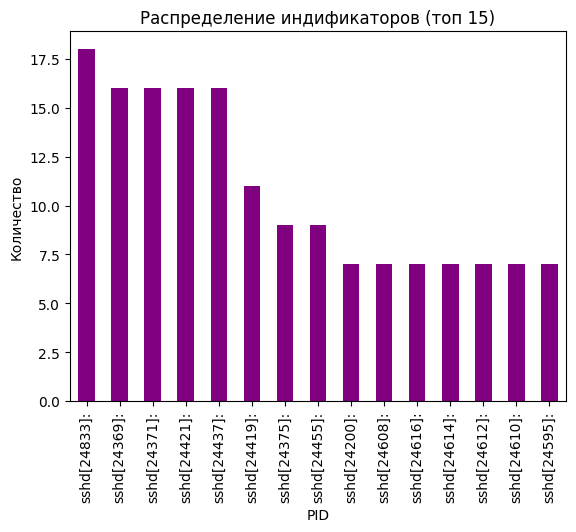

In [8]:
import matplotlib.pyplot as plt
log_df['Pid'].value_counts()[:15].plot(kind='bar', color ='purple')


plt.xlabel('PID')
plt.ylabel('Количество')
plt.title('Распределение индификаторов (топ 15)')
plt.show()

# Частота появления

<ipython-input-9-81ce5fb48322>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  log_df['Id'] = pd.to_datetime(log_df['Time'])


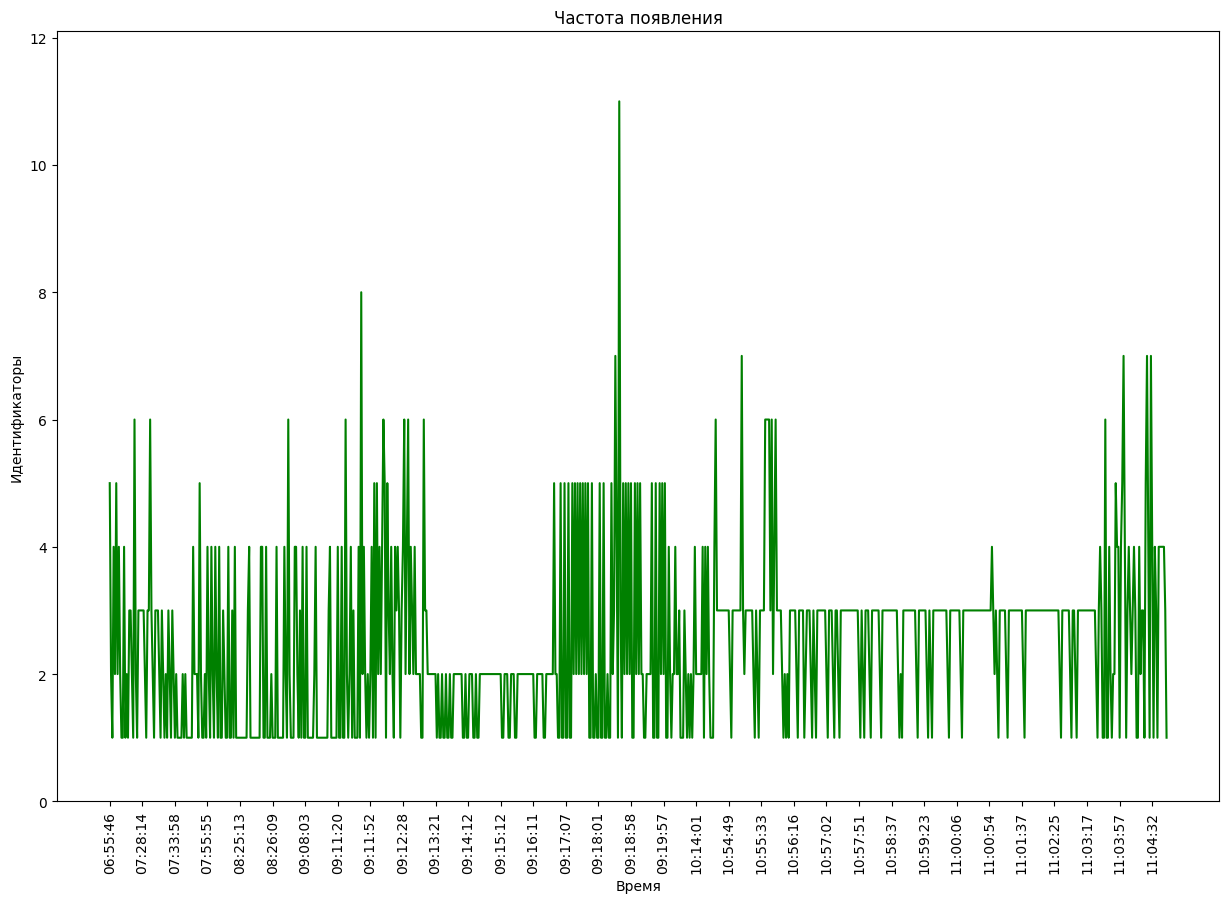

In [9]:
log_df['Id'] = pd.to_datetime(log_df['Time'])
cbs_count = log_df.groupby('Time').size()

plt.figure(figsize=(15, 10))
plt.plot(cbs_count.index, cbs_count.values, linestyle='-', color='green')
plt.xlabel('Время')
plt.ylabel('Идентификаторы')
plt.ylim(bottom=0, top=max(cbs_count.values) * 1.1)

step = 25
plt.xticks(cbs_count.index[::step], rotation=90)

plt.title('Частота появления')
plt.show()

# Количество событий

<ipython-input-13-c5a74500c52e>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  log_df['level'] = pd.to_datetime(log_df['Time'], errors='coerce')


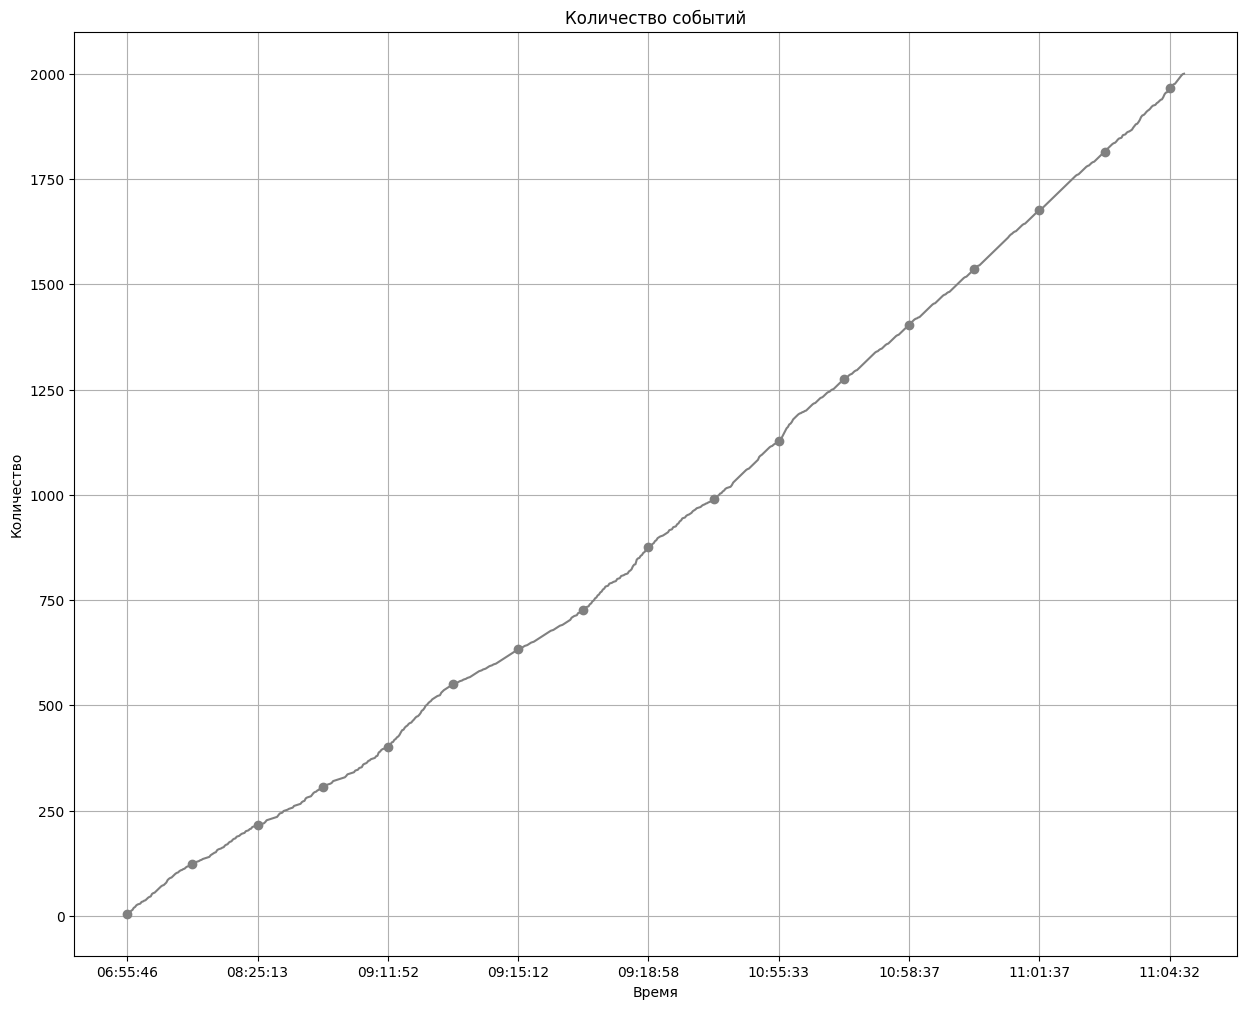

In [13]:
log_df['level'] = pd.to_datetime(log_df['Time'], errors='coerce')

events_per_time = log_df['Time'].dropna().value_counts().sort_index().cumsum()

plt.figure(figsize=(15, 12))
events_per_time.plot(marker='o', linestyle='-', color='grey', markevery=50)
plt.xlabel('Время')
plt.ylabel('Количество')
plt.grid(True)

plt.title('Количество событий')
plt.show()